In [14]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import imageio.v2 as imageio
from io import BytesIO
from IPython.display import HTML
import numpy as np
import torchvision
from torchvision import transforms, datasets
from IPython.display import Image
%matplotlib inline


In [ ]:
import matplotlib.pyplot as plt

# Eje de epochs: una por cada elemento de gd_loss
epochs = range(len(gd_loss))

fig, (ax11, ax21, ax31) = plt.subplots(1, 3, figsize=(20, 5))

# --------- 1) Cross entropy loss ---------
ax11.plot(epochs, gd_loss, label='gradient descent', color='C0')
ax11.plot(epochs, sgd_loss[:len(epochs)], label='stochastic gradient descent', color='C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

# --------- 2) Train accuracy ------------
ax21.plot(epochs, gd_train_acc, label='gradient descent', color='C0')
ax21.plot(epochs, sgd_train_acc[:len(epochs)], label='stochastic gradient descent', color='C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

# --------- 3) Test accuracy -------------
ax31.plot(epochs, gd_test_acc, label='gradient descent', color='C0')
ax31.plot(epochs, sgd_test_acc[:len(epochs)], label='stochastic gradient descent', color='C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

plt.show()


C:\Users\jorge\AppData\Local\Temp\ipykernel_34628\1066355578.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


# Notas: 

*   dim_in  :   nº de características de entrada
*   dim_out :   nº de neuronas de salida
*   act     :   función de activación (por ejemplo torch.relu)
*   neurons_hidden   :     lista con nº de neuronas por capa oculta, e.g. [32, 16]
*   hidden_activations :     lista de funciones de activación para cada capa oculta
*   link_function    :     función de enlace para la salida (p.ej. linear_link o torch.sigmoid)
*   loss_function    :   función de pérdida de PyTorch, p.ej. nn.MSELoss()

In [2]:
def linear_link(x):
    return x
    
class ActivationWrapper(nn.Module):
    def __init__(self, act_fn):
        super().__init__()
        self.act = act_fn
    def forward(self, x):
        return self.act(x)


class FCLayer(nn.Module):
    def __init__(self, dim_in, dim_out, act):
        super().__init__()
        self.linear = nn.Linear(dim_in, dim_out)
        self.act = act
        
    def forward(self, x):
        z = self.linear(x)
        if self.act is not None:
            z = self.act(z)
        return z


class FCDNN(nn.Module):
    def __init__(self, 
                 dim_in, 
                 dim_out, 
                 neurons_hidden : list, 
                 hidden_activations:list, 
                 dropout_hidden : list,
                 batch_norm: bool, 
                 add_residual: bool, 
                 link_function, 
                 loss_function):
        super().__init__()

        layers = nn.ModuleList([])
        in_dim = dim_in

   
        for n_neur, act, drop in zip(neurons_hidden, hidden_activations, dropout_hidden):

            block = nn.ModuleList([])

            # 1) LINEAR
            block.append(nn.Linear(in_dim, n_neur))

            # 2) BATCH NORM (si se pide)
            if batch_norm:
                block.append(nn.BatchNorm1d(n_neur))

            # 3) ACTIVACIÓN
            if act is not None:
                block.append(ActivationWrapper(act))

            # 4) DROPOUT (si se pide)
            if drop is not None and drop > 0:
                block.append(nn.Dropout(drop))

            # Guardar el bloque
            layers.append(block)

            # actualizar dim para siguiente capa
            in_dim = n_neur

        # ----------------------------
        # Capa de salida
        # ----------------------------
        self.output_layer = nn.Linear(in_dim, dim_out)

        # Residual flag
        self.add_residual = add_residual

        # Guardamos la arquitectura
        self.layers = layers

        # Link y loss
        self.link = link_function
        self.loss = loss_function


    def forward(self, x, apply_link=True):
        if x.dim() > 2:
            x = x.view(x.size(0), -1)
        out = x
        prev = x

        for block in self.layers:
            for layer in block:
                out = layer(out)

            # conexión residual (si procede)
            if self.add_residual and out.shape == prev.shape:
                out = out + prev
            
            prev = out

        # Capa final
        y = self.output_layer(out)

        if apply_link:
            y = self.link(y)

        return y


    def compute_loss(self, t, y):
        return self.loss(y, t)


In [3]:
## function domain
N_min = -10
N_max = 10
N_points = 100

x_range = torch.linspace(N_min, N_max, N_points).reshape(N_points, 1)

## num functions to display
N_fun = 5  

## Lets parameterize different models
activations = {
                'sigmoid' : torch.sigmoid, 
                'relu'    : torch.relu, 
                'tanh'    : torch.tanh
              }

num_hidden_layers = [1, 2, 3]           # número de capas ocultas
neurons_per_layer = [2, 10, 128]        # neuronas en cada capa

## create figure grid
fig, axes = plt.subplots(len(activations), 
                         len(num_hidden_layers) * len(neurons_per_layer), 
                         figsize = (200, 80))

for i_a, (act_n, act_p) in enumerate(activations.items()):
    ax_acts = axes[i_a]
    
    counter_ax = 0
    for i_h, num_h in enumerate(num_hidden_layers):
        for i_n, n_l in enumerate(neurons_per_layer):
            ax_neur = ax_acts[counter_ax]
            
            for n_fun in range(N_fun):

                model = FCDNN(
                    dim_in = 1, 
                    dim_out = 1, 
                    neurons_hidden = [n_l] * num_h, 
                    hidden_activations = [act_p] * num_h,
                    dropout_hidden = [0.0] * num_h,      # SIN dropout
                    batch_norm = False,
                    add_residual = False,
                    link_function = linear_link, 
                    loss_function = None
                )

                with torch.no_grad():
                    y_range = model.forward(x_range, apply_link = True)
                    ax_neur.plot(x_range, y_range, color = f'C{n_fun}', linewidth = 12)
            
            # etiqueta de filas (función de activación)
            if counter_ax == 0:
                ax_neur.set_ylabel(f'{act_n}', fontsize = 60)
            
            # título encima de cada columna
            ax_neur.set_title(f'Layers: {num_h} | Neurons: {n_l}', fontsize = 55)
            ax_neur.tick_params(axis='both', labelsize=40)
            
            counter_ax += 1


In [4]:
!pip install imageio[ffmpeg]



[notice] A new release of pip available: 22.2.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


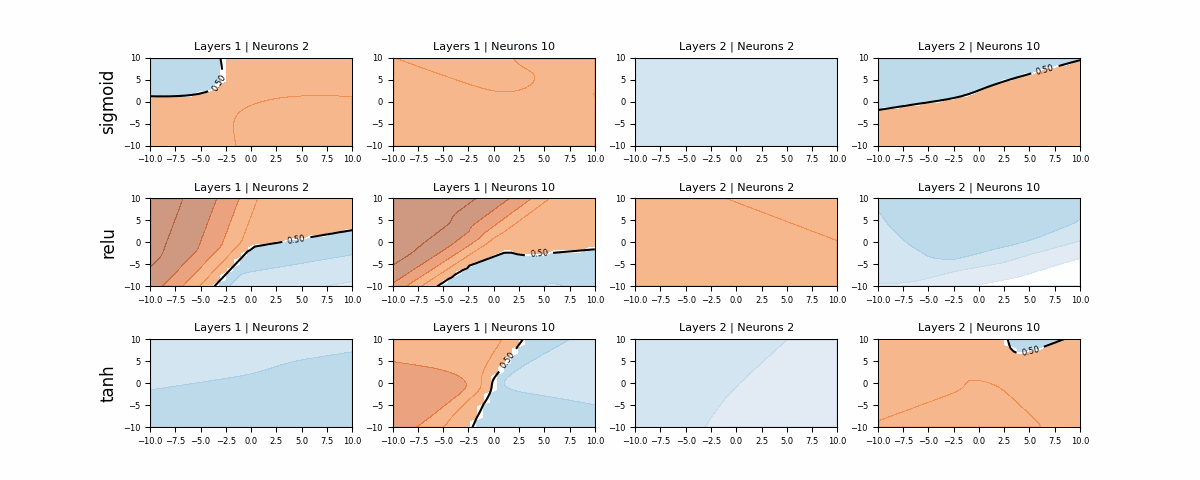

In [5]:
plt.switch_backend("Agg")




#############################################
# --- TU MODELO FCDNN (DEBE ESTAR DEFINIDO) 
#############################################

# Asegúrate de haber definido FCLayer, linear_link y FCDNN antes.


#############################################
# --- CONFIGURACIÓN DEL DOMINIO 2D
#############################################

N_min = -10
N_max = 10
N_points_domain = 30
thr_prob = 0.5

x1, x2 = np.meshgrid(
    np.linspace(N_min, N_max, N_points_domain, dtype=np.float32),
    np.linspace(N_min, N_max, N_points_domain, dtype=np.float32)
)

# reshape para meter en la red
x_range = torch.from_numpy(
    np.hstack((x1.reshape(-1, 1), x2.reshape(-1, 1)))
).float()

# buffer para visualización
y_range_plot = np.zeros((N_points_domain, N_points_domain), np.float32)


#############################################
# --- PARÁMETROS DE LAS REDES
#############################################

N_fun = 10     # nº de frames del GIF

activations = {
    'sigmoid': torch.sigmoid,
    'relu': torch.relu,
    'tanh': torch.tanh
}

num_hidden_layers = [1, 2]
neurons_per_layer = [2, 10]


#############################################
# --- FIGURA Y GENERACIÓN DEL GIF
#############################################

fig, axes = plt.subplots(
    len(activations),
    len(num_hidden_layers) * len(neurons_per_layer),
    figsize=(12, 4.8)
)
plt.subplots_adjust(hspace=0.6)

video_filename = "decision_regions.gif"
writer = imageio.get_writer(video_filename, mode="I", fps=2)


#############################################
# --- BUCLE PRINCIPAL
#############################################

for n_fun in range(N_fun):

    for i_a, (act_name, act_fn) in enumerate(activations.items()):
        ax_row = axes[i_a]
        counter_ax = 0

        for num_h in num_hidden_layers:
            for n_l in neurons_per_layer:

                ax = ax_row[counter_ax]
                ax.cla()

                # Crear modelo aleatorio
                model = FCDNN(
                    dim_in=2,
                    dim_out=1,
                    neurons_hidden=[n_l] * num_h,
                    hidden_activations=[act_fn] * num_h,
                    dropout_hidden=[0.0] * num_h,
                    batch_norm=False,
                    add_residual=False,
                    link_function=torch.sigmoid,
                    loss_function=None
                )

                with torch.no_grad():
                    # Forward
                    y_range = model.forward(x_range, apply_link=True)
                    y_range = y_range.reshape(N_points_domain, N_points_domain)

                    # Clase 1
                    idx1 = y_range > thr_prob
                    idx0 = ~idx1

                    y_range_plot[idx1] = y_range[idx1]
                    y_range_plot[idx0] = np.nan

                    ax.contourf(
                        x1, x2, y_range_plot,
                        levels=np.linspace(0, 1, 11),
                        cmap="Oranges", alpha=0.5
                    )

                    # Clase 0
                    y_range_plot[idx0] = y_range[idx0]
                    y_range_plot[idx1] = np.nan

                    ax.contourf(
                        x1, x2, y_range_plot,
                        levels=np.linspace(0, 1, 11),
                        cmap="Blues", alpha=0.5
                    )

                    # Línea de decisión
                    contour = ax.contour(
                        x1, x2, y_range,
                        levels=[thr_prob],
                        colors=["k"]
                    )
                    ax.clabel(contour, inline=True, fontsize=6, fmt="%.2f")

                if counter_ax == 0:
                    ax.set_ylabel(f"{act_name}", fontsize=12)

                ax.set_title(f"Layers {num_h} | Neurons {n_l}", fontsize=8)
                ax.tick_params(axis="both", labelsize=6)

                counter_ax += 1

    # --- guardar frame ---
    fig.canvas.draw()
    buf = BytesIO()
    fig.savefig(buf, format="png", dpi=100)
    buf.seek(0)
    writer.append_data(imageio.imread(buf))

writer.close()
plt.close()


#############################################
# --- MOSTRAR GIF EN VS CODE
#############################################

Image(filename=video_filename)


# Definimos el "motor": Red Fully cocnnected

In [6]:

transform = transforms.Compose([
    transforms.ToTensor(),
])

#Cargamos data train
train_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True
)
#Cargamos data test

test_dataset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    transform=transform,
    download=True
)

#Recibimos 100 imágenes
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=100,
    shuffle=True
)

#Evaluamos 1000 imagenes
train_loader_eval = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=1000,
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1000,
    shuffle=False
)

N_training = len(train_dataset)
N_test = len(test_dataset)

print("MNIST data loaded correctly.")
print(f"Training samples: {N_training}")
print(f"Test samples: {N_test}")


MNIST data loaded correctly.
Training samples: 60000
Test samples: 10000


In [7]:
number_input_neurons  = 784        # 28 x 28  
number_output_neurons = 10         # dígitos 0–9
link_function  = linear_link

In [8]:
def compute_metric(dataloader, model):
    acc = 0.0
    tot_samples = 0

    model.eval()                      # modo evaluación (desactiva dropout)
    with torch.no_grad():             # no calculamos gradientes
        for x, t in dataloader:
            ## mover a device
            x, t = x.to(device), t.to(device)

           
            y = model(x, apply_link=False)  # y tiene shape [batch, 10]

            ## predicción = índice del máximo logit

            y_pred = torch.argmax(y, dim=1)  

            ## nº de aciertos en este batch
            acc += (y_pred == t).sum().item()

            ## nº total de muestras procesadas
            tot_samples += len(t)

    return acc / tot_samples


In [9]:
def test_model(
    model : torch.nn.Module, 
    epochs : int,  
    train_batch_size : int, 
    lr : float, 
    mmu : float, 
    apply_scheduler : bool, 
    eval_each : int, 
    train_dataset : torchvision.datasets.MNIST,  
    test_dataset : torchvision.datasets.MNIST
):
    # ============================
    # DATALOADERS
    # ============================
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=train_batch_size,
        shuffle=True
    )

    train_loader_eval = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=1000,
        shuffle=False
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=1000,
        shuffle=False
    )

    # Stats
    N_training = len(train_dataset)
    N_test = len(test_dataset)

    model.to(device)

    # LISTAS PARA GUARDAR RESULTADOS
    loss_epochs = []
    train_acc_epochs = []
    test_acc_epochs = []

    # ============================
    # MÉTRICAS INICIALES (EPOCH 0)
    # ============================
    model.eval()
    with torch.no_grad():
        loss_acc = 0.0
        for x, t in train_loader_eval:
            x, t = x.to(device), t.to(device)
            y = model(x, apply_link=False)
            L = model.compute_loss(t, y)
            loss_acc += len(x) * L.item()

        train_acc = compute_metric(train_loader_eval, model)
        test_acc  = compute_metric(test_loader, model)

    loss_epochs.append(loss_acc / N_training)
    train_acc_epochs.append(train_acc)
    test_acc_epochs.append(test_acc)

    print(f"[Init] Loss={loss_acc/N_training:.4f} | Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f}")

    # ============================
    # OPTIMIZER / SCHEDULER
    # ============================
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mmu)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=[10], gamma=0.1
    )

    # ============================
    # TRAINING LOOP
    # ============================
    for e in range(epochs):

        model.train()
        loss_acc = 0.0

        for batch_idx, (x,t) in enumerate(train_loader):
            x, t = x.to(device), t.to(device)

            # FORWARD
            y = model(x, apply_link=False)
            L = model.compute_loss(t, y)
            loss_acc += len(x) * L.item()

            # BACKPROP
            optimizer.zero_grad()
            L.backward()

            #Actualiza los pesos
            optimizer.step()

            print(
                f"Epoch {e+1}/{epochs} | Batch {batch_idx+1}/{len(train_loader)} | Loss={L.item():.5f}",
                end="\r"
            )

        if apply_scheduler:
            scheduler.step()

        # EVALUACIÓN PERIÓDICA
        if (e+1) % eval_each == 0:
            model.eval()
            with torch.no_grad():
                train_acc = compute_metric(train_loader_eval, model)
                test_acc  = compute_metric(test_loader, model)

            print(" " * 200, end="\r")
            print(
                f"[Epoch {e+1}] Loss={loss_acc/N_training:.4f} "
                f"| Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f}"
            )
        else:
            # Si no evaluamos, repetimos último valor
            train_acc = train_acc_epochs[-1]
            test_acc  = test_acc_epochs[-1]
            print(" " * 200, end="\r")
            print(f"[Epoch {e+1}] Loss={loss_acc/N_training:.4f}")

        # Guardamos métricas
        loss_epochs.append(loss_acc/N_training)
        train_acc_epochs.append(train_acc)
        test_acc_epochs.append(test_acc)

    return loss_epochs, train_acc_epochs, test_acc_epochs


In [10]:
import torch
import torch.nn.functional as F

torch.manual_seed(0)
device = "cpu"

dim_in = 28 * 28     # 784
dim_out = 10  


model = FCDNN(
    dim_in           = dim_in,
    dim_out          = dim_out,
    neurons_hidden   = [],            # sin capas ocultas
    hidden_activations = [],
    dropout_hidden   = [],            # sin dropouts (no hay hidden)
    batch_norm       = False,
    add_residual     = False,
    link_function    = (lambda x: x),   # identidad
    loss_function    = F.cross_entropy, # loss real
)


gd_loss, gd_train_acc, gd_test_acc = test_model(
    model,
    epochs           = 10,
    train_batch_size = 60000,   # Gradient Descent puro
    lr               = 0.1,
    mmu              = 1,     # momentum
    apply_scheduler  = False,
    eval_each        = 1,
    train_dataset    = train_dataset,
    test_dataset     = test_dataset
)

model_sgd = FCDNN(
    dim_in = dim_in,
    dim_out = dim_out,
    neurons_hidden = [],          
    hidden_activations = [],
    dropout_hidden   = [],  
    batch_norm = False, 
    add_residual = False,
    link_function = (lambda x: x),   
    loss_function = F.cross_entropy, 
)
model_sgd.to(device)

sgd_loss, sgd_train_acc, sgd_test_acc = test_model(
    model_sgd,
    epochs           = 10,
    train_batch_size = 32,   # <-- aquí está el SGD
    lr               = 0.01,
    mmu              = 0.9,
    apply_scheduler  = False,
    eval_each        = 1,
    train_dataset    = train_dataset,
    test_dataset     = test_dataset
)

[Init] Loss=2.3496 | Train Acc=0.0557 | Test Acc=0.0540
[Epoch 1] Loss=2.3496 | Train Acc=0.1673 | Test Acc=0.1709                                                                                                                                              
[Epoch 2] Loss=2.2388 | Train Acc=0.5109 | Test Acc=0.5232                                                                                                                                              
[Epoch 3] Loss=2.0405 | Train Acc=0.6589 | Test Acc=0.6648                                                                                                                                              
[Epoch 4] Loss=1.7887 | Train Acc=0.7157 | Test Acc=0.7210                                                                                                                                              
[Epoch 5] Loss=1.5176 | Train Acc=0.7471 | Test Acc=0.7530                                                                                  

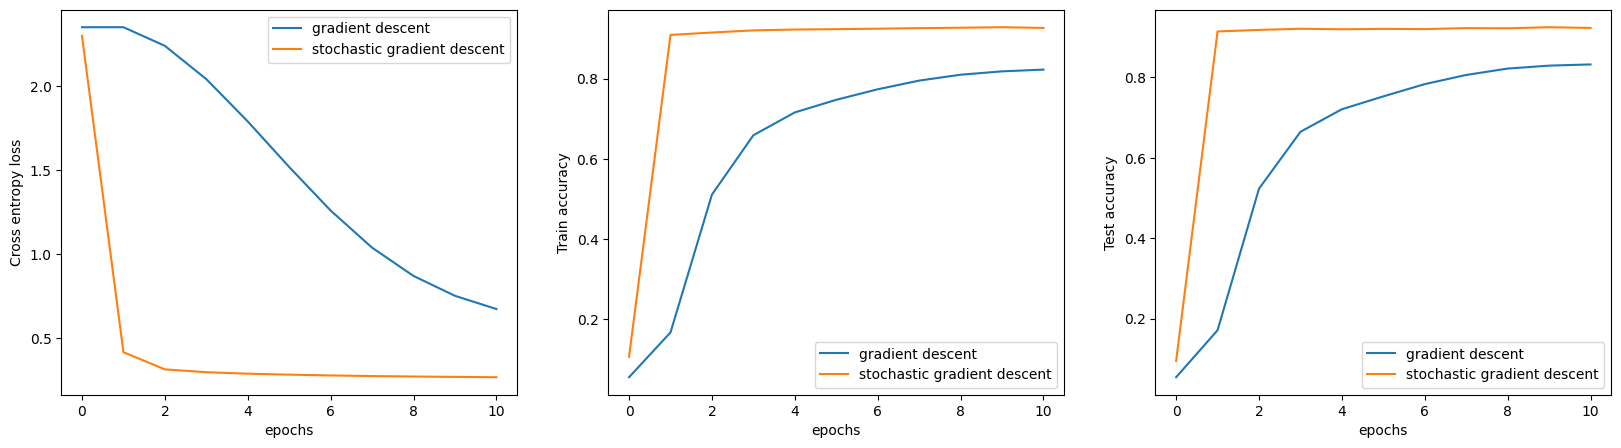

In [16]:
import matplotlib.pyplot as plt

epochs_gd  = range(len(gd_loss))     
epochs_sgd = range(len(sgd_loss))     

fig, (ax11, ax21, ax31) = plt.subplots(1, 3, figsize=(20, 5))

## Plot cross entropy loss
ax11.plot(epochs_gd,  gd_loss,  label='gradient descent',           color='C0')
ax11.plot(epochs_sgd, sgd_loss, label='stochastic gradient descent', color='C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(epochs_gd,  gd_train_acc,  label='gradient descent',           color='C0')
ax21.plot(epochs_sgd, sgd_train_acc, label='stochastic gradient descent', color='C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(epochs_gd,  gd_test_acc,  label='gradient descent',           color='C0')
ax31.plot(epochs_sgd, sgd_test_acc, label='stochastic gradient descent', color='C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

plt.show()


In [17]:
torch.manual_seed(0)
device = "cpu"

dim_in  = 28 * 28  
dim_out = 10    

model_sgd = FCDNN(
    dim_in = dim_in,
    dim_out = dim_out,
    neurons_hidden = [32],          
    hidden_activations = [F.relu],
    dropout_hidden   = [],  
    batch_norm = False, 
    add_residual = False,
    link_function = (lambda x: x),   
    loss_function = F.cross_entropy, 
)
model_sgd.to(device)

sgd_loss, sgd_train_acc, sgd_test_acc = test_model(
    model_sgd,
    epochs           = 10,
    train_batch_size = 100,   
    lr               = 0.1,
    mmu              = 0.0,
    apply_scheduler  = False,
    eval_each        = 1,
    train_dataset    = train_dataset,
    test_dataset     = test_dataset
)

[Init] Loss=2.3496 | Train Acc=0.0557 | Test Acc=0.0540
[Epoch 1] Loss=0.5367 | Train Acc=0.8946 | Test Acc=0.9025                                                                                                                                              
[Epoch 2] Loss=0.3595 | Train Acc=0.9058 | Test Acc=0.9099                                                                                                                                              
[Epoch 3] Loss=0.3311 | Train Acc=0.9104 | Test Acc=0.9154                                                                                                                                              
[Epoch 4] Loss=0.3165 | Train Acc=0.9145 | Test Acc=0.9176                                                                                                                                              
[Epoch 5] Loss=0.3070 | Train Acc=0.9149 | Test Acc=0.9164                                                                                  

In [20]:
torch.manual_seed(0)
device = "cpu"

dim_in  = 28 * 28  
dim_out = 10    

model_sgd = FCDNN(
    dim_in = dim_in,
    dim_out = dim_out,
    neurons_hidden = [32],          
    hidden_activations = [F.relu],
    dropout_hidden   = [],  
    batch_norm = False, 
    add_residual = False,
    link_function = (lambda x: x),   
    loss_function = F.cross_entropy, 
)
model_sgd.to(device)

sgd_loss_m, sgd_train_acc_m, sgd_test_acc_m = test_model(
    model_sgd,
    epochs           = 10,
    train_batch_size = 100,   
    lr               = 0.1,
    mmu              = 0.9,
    apply_scheduler  = False,
    eval_each        = 1,
    train_dataset    = train_dataset,
    test_dataset     = test_dataset
)

[Init] Loss=2.3496 | Train Acc=0.0557 | Test Acc=0.0540
[Epoch 1] Loss=0.3698 | Train Acc=0.9159 | Test Acc=0.9167                                                                                                                                              
[Epoch 2] Loss=0.3011 | Train Acc=0.9203 | Test Acc=0.9204                                                                                                                                              
[Epoch 3] Loss=0.2911 | Train Acc=0.9220 | Test Acc=0.9191                                                                                                                                              
[Epoch 4] Loss=0.2841 | Train Acc=0.9248 | Test Acc=0.9188                                                                                                                                              
[Epoch 5] Loss=0.2806 | Train Acc=0.9193 | Test Acc=0.9160                                                                                  

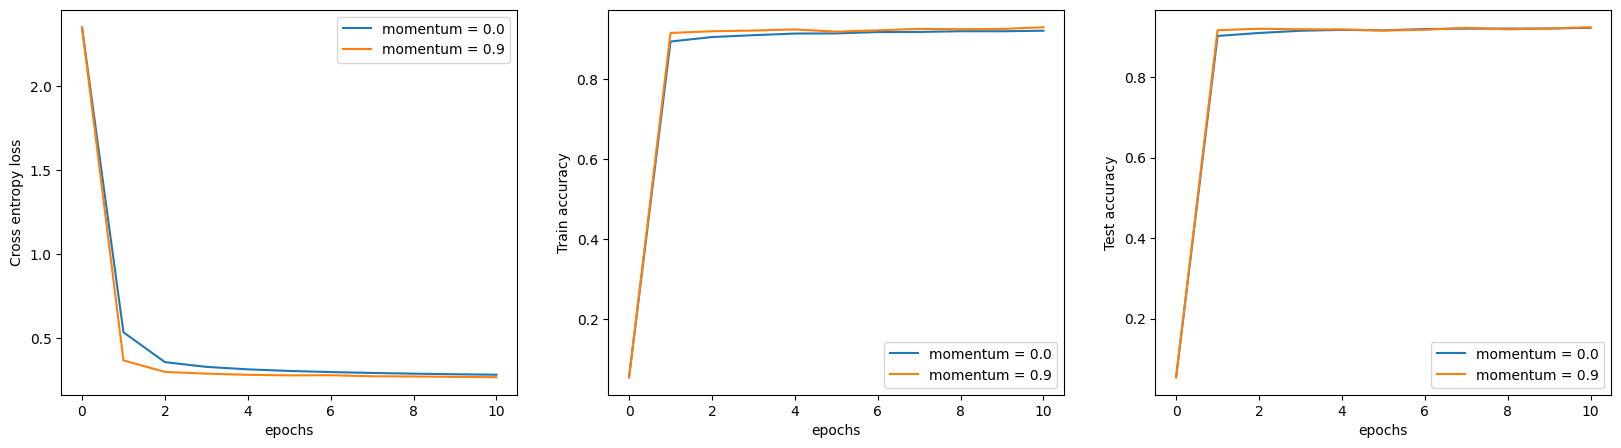

In [22]:
import matplotlib.pyplot as plt

epochs_sgd  = range(len(sgd_loss))     
epochs_sgd_m = range(len(sgd_loss_m))     

fig, (ax11, ax21, ax31) = plt.subplots(1, 3, figsize=(20, 5))

## Plot cross entropy loss
ax11.plot(epochs_sgd,  sgd_loss,  label='momentum = 0.0',         color='C0')
ax11.plot(epochs_sgd_m, sgd_loss_m, label='momentum = 0.9', color='C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(epochs_sgd,  sgd_train_acc,  label='momentum = 0.0',           color='C0')
ax21.plot(epochs_sgd_m, sgd_train_acc_m, label='momentum = 0.9', color='C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(epochs_sgd,  sgd_test_acc,  label='momentum = 0.0',           color='C0')
ax31.plot(epochs_sgd_m, sgd_test_acc_m, label='momentum = 0.9', color='C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

plt.show()


In [28]:
torch.manual_seed(0)
device = "cpu"

dim_in  = 28 * 28  
dim_out = 10    

model_sgd = FCDNN(
    dim_in = dim_in,
    dim_out = dim_out,
    neurons_hidden = [],          
    hidden_activations = [F.relu],
    dropout_hidden   = [],  
    batch_norm = False, 
    add_residual = False,
    link_function = (lambda x: x),   
    loss_function = F.cross_entropy, 
)
model_sgd.to(device)

sgd_loss_1, sgd_train_acc_1, sgd_test_acc_1 = test_model(
    model_sgd,
    epochs           = 10,
    train_batch_size = 100,   
    lr               = 0.99,
    mmu              = 0.9,
    apply_scheduler  = False,
    eval_each        = 1,
    train_dataset    = train_dataset,
    test_dataset     = test_dataset
)

[Init] Loss=2.3496 | Train Acc=0.0557 | Test Acc=0.0540
[Epoch 1] Loss=1.0593 | Train Acc=0.8828 | Test Acc=0.8864                                                                                                                                              
[Epoch 2] Loss=0.9112 | Train Acc=0.8618 | Test Acc=0.8594                                                                                                                                              
[Epoch 3] Loss=0.8831 | Train Acc=0.9043 | Test Acc=0.9014                                                                                                                                              
[Epoch 4] Loss=0.9243 | Train Acc=0.8966 | Test Acc=0.8933                                                                                                                                              
[Epoch 5] Loss=0.9322 | Train Acc=0.9096 | Test Acc=0.9061                                                                                  

In [26]:
torch.manual_seed(0)
device = "cpu"

dim_in  = 28 * 28  
dim_out = 10    

model_sgd = FCDNN(
    dim_in = dim_in,
    dim_out = dim_out,
    neurons_hidden = [],          
    hidden_activations = [F.relu],
    dropout_hidden   = [],  
    batch_norm = False, 
    add_residual = False,
    link_function = (lambda x: x),   
    loss_function = F.cross_entropy, 
)
model_sgd.to(device)

sgd_loss_2, sgd_train_acc_2, sgd_test_acc_2 = test_model(
    model_sgd,
    epochs           = 10,
    train_batch_size = 100,   
    lr               = 0.01,
    mmu              = 0.9,
    apply_scheduler  = False,
    eval_each        = 1,
    train_dataset    = train_dataset,
    test_dataset     = test_dataset
)

[Init] Loss=2.3496 | Train Acc=0.0557 | Test Acc=0.0540
[Epoch 1] Loss=0.5452 | Train Acc=0.8943 | Test Acc=0.9006                                                                                                                                              
[Epoch 2] Loss=0.3587 | Train Acc=0.9053 | Test Acc=0.9116                                                                                                                                              
[Epoch 3] Loss=0.3310 | Train Acc=0.9103 | Test Acc=0.9148                                                                                                                                              
[Epoch 4] Loss=0.3164 | Train Acc=0.9142 | Test Acc=0.9187                                                                                                                                              
[Epoch 5] Loss=0.3068 | Train Acc=0.9150 | Test Acc=0.9165                                                                                  

In [27]:
torch.manual_seed(0)
device = "cpu"

dim_in  = 28 * 28  
dim_out = 10    

model_sgd = FCDNN(
    dim_in = dim_in,
    dim_out = dim_out,
    neurons_hidden = [],          
    hidden_activations = [F.relu],
    dropout_hidden   = [],  
    batch_norm = False, 
    add_residual = False,
    link_function = (lambda x: x),   
    loss_function = F.cross_entropy, 
)
model_sgd.to(device)

sgd_loss_3, sgd_train_acc_3, sgd_test_acc_3 = test_model(
    model_sgd,
    epochs           = 10,
    train_batch_size = 100,   
    lr               = 0.001,
    mmu              = 0.9,
    apply_scheduler  = False,
    eval_each        = 1,
    train_dataset    = train_dataset,
    test_dataset     = test_dataset
)

[Init] Loss=2.3496 | Train Acc=0.0557 | Test Acc=0.0540
[Epoch 1] Loss=1.1719 | Train Acc=0.8430 | Test Acc=0.8528                                                                                                                                              
[Epoch 2] Loss=0.6434 | Train Acc=0.8639 | Test Acc=0.8724                                                                                                                                              
[Epoch 3] Loss=0.5366 | Train Acc=0.8737 | Test Acc=0.8815                                                                                                                                              
[Epoch 4] Loss=0.4853 | Train Acc=0.8807 | Test Acc=0.8888                                                                                                                                              
[Epoch 5] Loss=0.4538 | Train Acc=0.8844 | Test Acc=0.8931                                                                                  

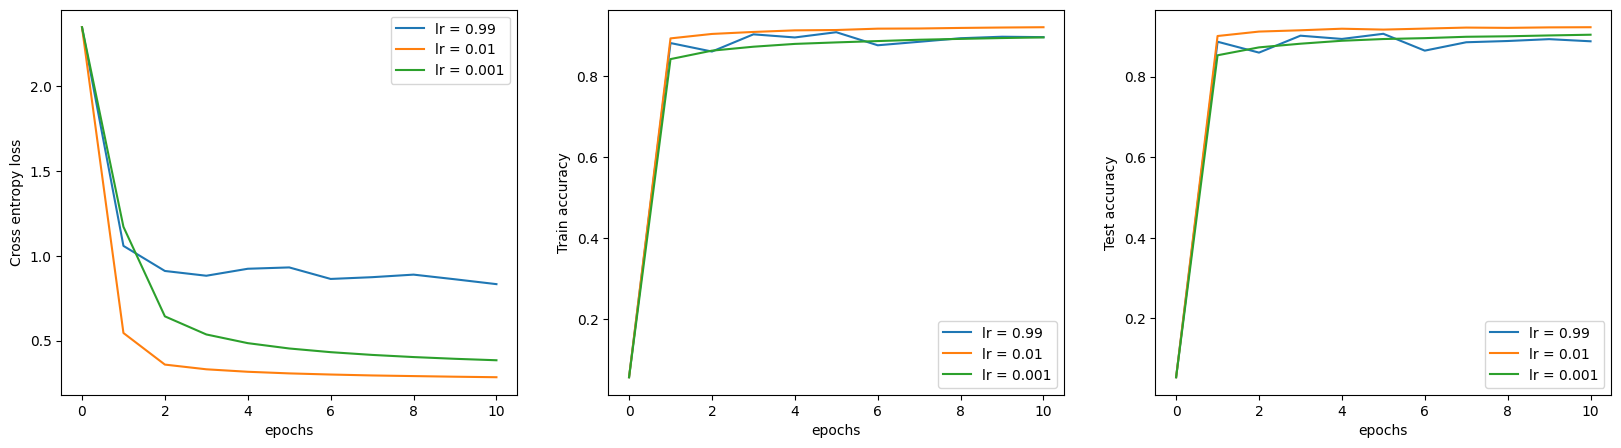

In [35]:
import matplotlib.pyplot as plt

epochs_sgd_1  = range(len(sgd_loss_1))     
epochs_sgd_2 = range(len(sgd_loss_2))     
epochs_sgd_3 = range(len(sgd_loss_3))     


fig, (ax11, ax21, ax31) = plt.subplots(1, 3, figsize=(20, 5))

## Plot cross entropy loss
ax11.plot(epochs_sgd_1,  sgd_loss_1,  label='lr = 0.99',         color='C0')
ax11.plot(epochs_sgd_2, sgd_loss_2, label='lr = 0.01', color='C1')
ax11.plot(epochs_sgd_3, sgd_loss_3, label='lr = 0.001', color='C2')

ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(epochs_sgd_1,  sgd_train_acc_1,  label='lr = 0.99',           color='C0')
ax21.plot(epochs_sgd_2, sgd_train_acc_2, label='lr = 0.01', color='C1')
ax21.plot(epochs_sgd_3, sgd_train_acc_3, label='lr = 0.001', color='C2')

ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(epochs_sgd_1,  sgd_test_acc_1,  label='lr = 0.99',           color='C0')
ax31.plot(epochs_sgd_2, sgd_test_acc_2, label='lr = 0.01', color='C1')
ax31.plot(epochs_sgd_3, sgd_test_acc_3, label='lr = 0.001', color='C2')

ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

plt.show()


In [ ]:
torch.manual_seed(0)
device = "cpu"

dim_in  = 28 * 28  
dim_out = 10    
n_l = 5
model_sgd = FCDNN(
    dim_in = dim_in,
    dim_out = dim_out,
    neurons_hidden = [32]*n_l,          
    hidden_activations = [F.relu]* n_l,
    dropout_hidden   = [],  
    batch_norm = False, 
    add_residual = False,
    link_function = (lambda x: x),   
    loss_function = F.cross_entropy, 
)
model_sgd.to(device)

sgd_loss_normal, sgd_train_acc_normal, sgd_test_acc_normal = test_model(
    model_sgd,
    epochs           = 20,
    train_batch_size = 100,   
    lr               = 0.1,
    mmu              = 0.9,
    apply_scheduler  = False,
    eval_each        = 1,
    train_dataset    = train_dataset,
    test_dataset     = test_dataset
)

[Init] Loss=2.3496 | Train Acc=0.0557 | Test Acc=0.0540
[Epoch 1] Loss=0.3698 | Train Acc=0.9159 | Test Acc=0.9167                                                                                                                                              
[Epoch 2] Loss=0.3011 | Train Acc=0.9203 | Test Acc=0.9204                                                                                                                                              
[Epoch 3] Loss=0.2911 | Train Acc=0.9220 | Test Acc=0.9191                                                                                                                                              
[Epoch 4] Loss=0.2841 | Train Acc=0.9248 | Test Acc=0.9188                                                                                                                                              
[Epoch 5] Loss=0.2806 | Train Acc=0.9193 | Test Acc=0.9160                                                                                  

In [ ]:
torch.manual_seed(0)
device = "cpu"

dim_in  = 28 * 28  
dim_out = 10    
n_l = 5
model_sgd = FCDNN(
    dim_in = dim_in,
    dim_out = dim_out,
    neurons_hidden = [32]*n_l,          
    hidden_activations = [F.relu]* n_l,
    dropout_hidden   = [],  
    batch_norm = False, 
    add_residual = False,
    link_function = (lambda x: x),   
    loss_function = F.cross_entropy, 
)
model_sgd.to(device)

sgd_loss_scheduler, sgd_train_acc_scheduler, sgd_test_acc_scheduler = test_model(
    model_sgd,
    epochs           = 20,
    train_batch_size = 100,   
    lr               = 0.1,
    mmu              = 0.9,
    apply_scheduler  = False,
    eval_each        = 1,
    train_dataset    = train_dataset,
    test_dataset     = test_dataset
)

In [ ]:
import matplotlib.pyplot as plt

epochs_sgd_normal  = range(len(sgd_loss_normal))     
epochs_sgd_scheduler = range(len(sgd_loss_scheduler))     

fig, (ax11, ax21, ax31) = plt.subplots(1, 3, figsize=(20, 5))

## Plot cross entropy loss
ax11.plot(epochs_sgd_normal,  sgd_loss_normal,  label='scheduler NO',         color='C0')
ax11.plot(epochs_sgd_scheduler, sgd_loss_scheduler, label='scheduler YES', color='C1')
ax11.set_ylabel('Cross entropy loss')
ax11.set_xlabel('epochs')
ax11.legend()

## Plot train acc
ax21.plot(epochs_sgd_normal,  sgd_train_acc_normal, label='scheduler NO',           color='C0')
ax21.plot(epochs_sgd_scheduler, sgd_train_acc_scheduler,  label='scheduler YES', color='C1')
ax21.set_ylabel('Train accuracy')
ax21.set_xlabel('epochs')
ax21.legend()

## Plot test acc
ax31.plot(epochs_sgd_normal,  sgd_test_acc_normal,  label='scheduler NO',           color='C0')
ax31.plot(epochs_sgd_scheduler, sgd_test_acc_scheduler,  label='scheduler YES', color='C1')
ax31.set_ylabel('Test accuracy')
ax31.set_xlabel('epochs')
ax31.legend()

plt.show()
